In [1]:
GPU_PKG_NAME = "CUDA"; include("common_definitions.jl");

  Activating environment at `~/juliacon21-gpu_workshop/Project.toml`


In [2]:
using ImageFiltering, ColorTypes, FixedPointNumbers, TensorCore
using FileIO, ImageMagick, ImageShow
using BenchmarkTools

using Dagger, DaggerGPU

# This lets us map from Dagger Processor to KA Backend
function dagger_backend()
    if !Dagger.in_thunk()
        return CUDADevice()
    end
    proc = Dagger.thunk_processor()
    if proc isa Dagger.ThreadProc
        return CPU()
    elseif proc isa DaggerGPU.CuArrayDeviceProc
        return CUDADevice()
    else
        return CPU() # fallback
    end
end

# Setup a proclist for CPUs and for GPUs
cpu_proclist = [Dagger.ThreadProc]
gpu_proclist = [DaggerGPU.CuArrayDeviceProc]

1-element Vector{DataType}:
 CuArrayDeviceProc

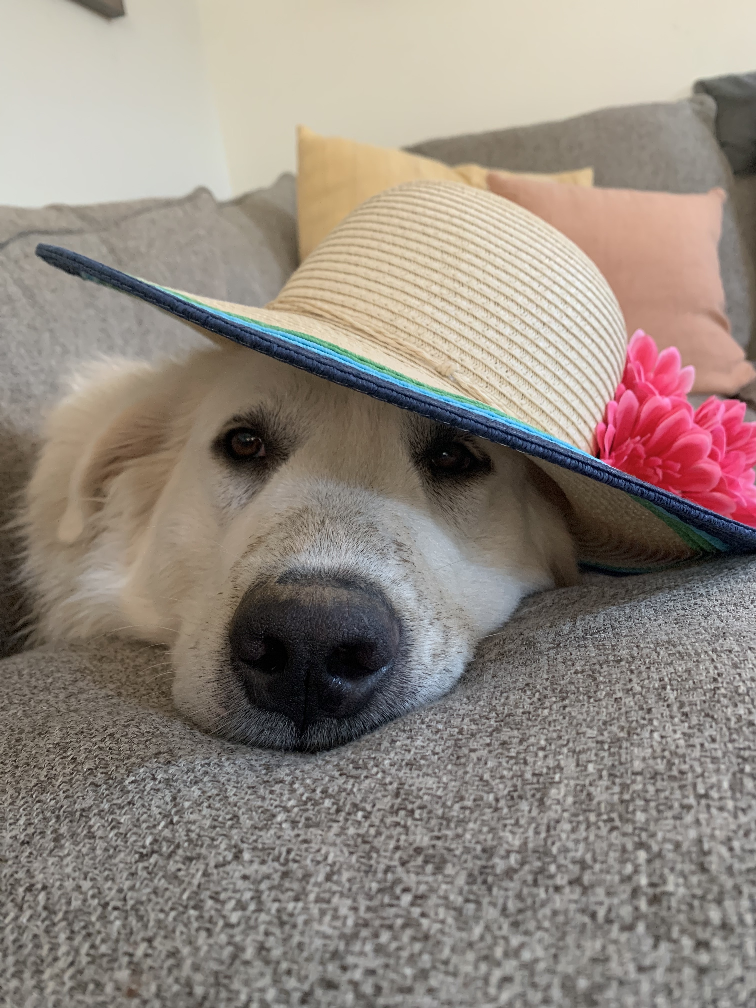

┌ Info: For better quality inline display of large images or thumbnails, load the Images package.
└ @ ImageShow /home/jpsamaroo/.julia/packages/ImageShow/11zF7/src/showmime.jl:131


In [3]:
# Load our image as a CPU Array
lilly = FileIO.load("Lilly_hat.jpg")

Now that we have our image in a CPU array (`Array`), we can convert it to a GPU array (`CuArray`). We need to be careful not to return the GPU array in a Jupyter cell, otherwise we'll hang Jupyter while it tries to read each array index from the GPU one-by-one!

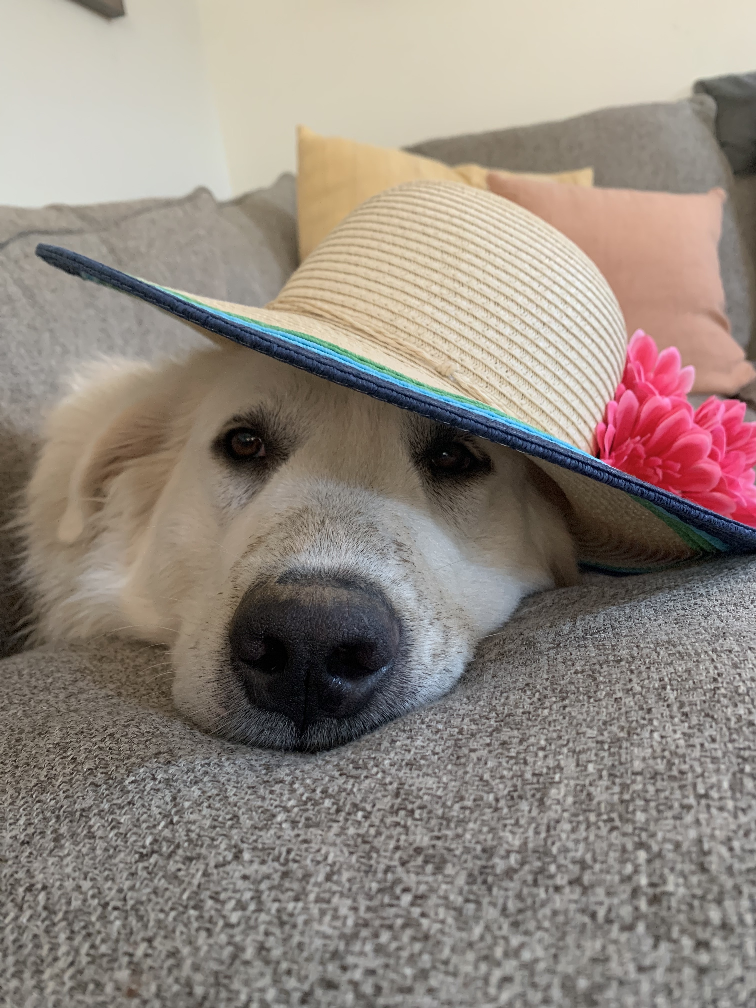

In [4]:
lilly_gpu = GpuArray(map(RGB{Float32}, lilly))
# Let's be careful to not render a GPU array! Scalar indexing is *slow*
Array(lilly_gpu)

Let's do some simple image operations on this image. Let's start with a basic negative:

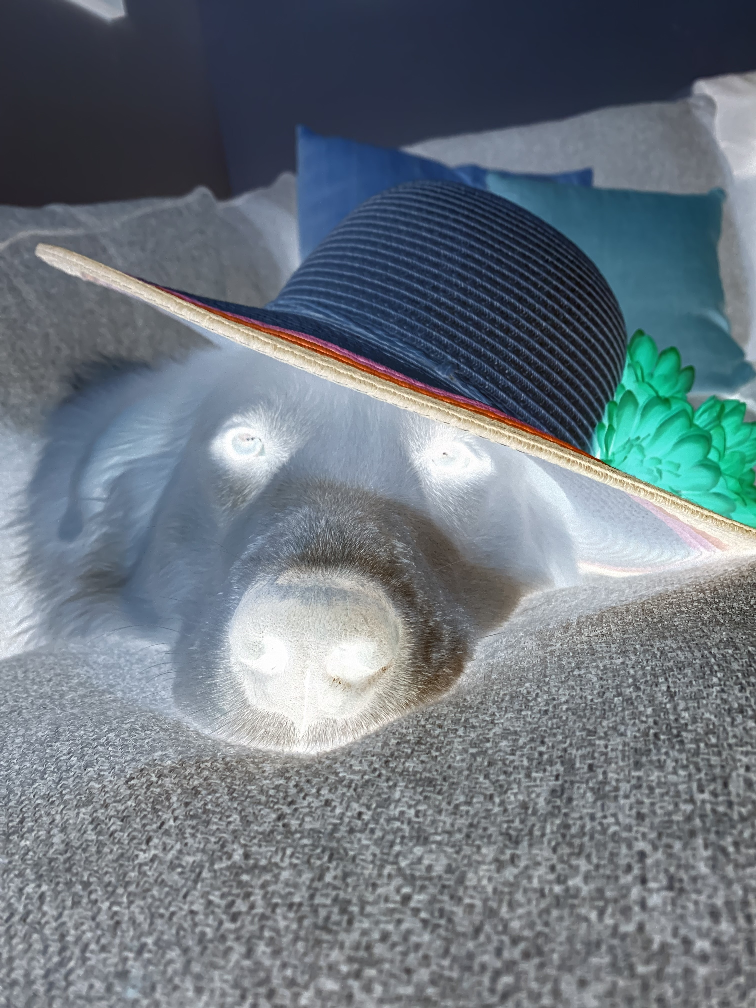

In [5]:
lilly_negative = RGB(1) .- lilly_gpu
Array(lilly_negative)

Cool! We can also adjust the brightness of the image pretty easily:

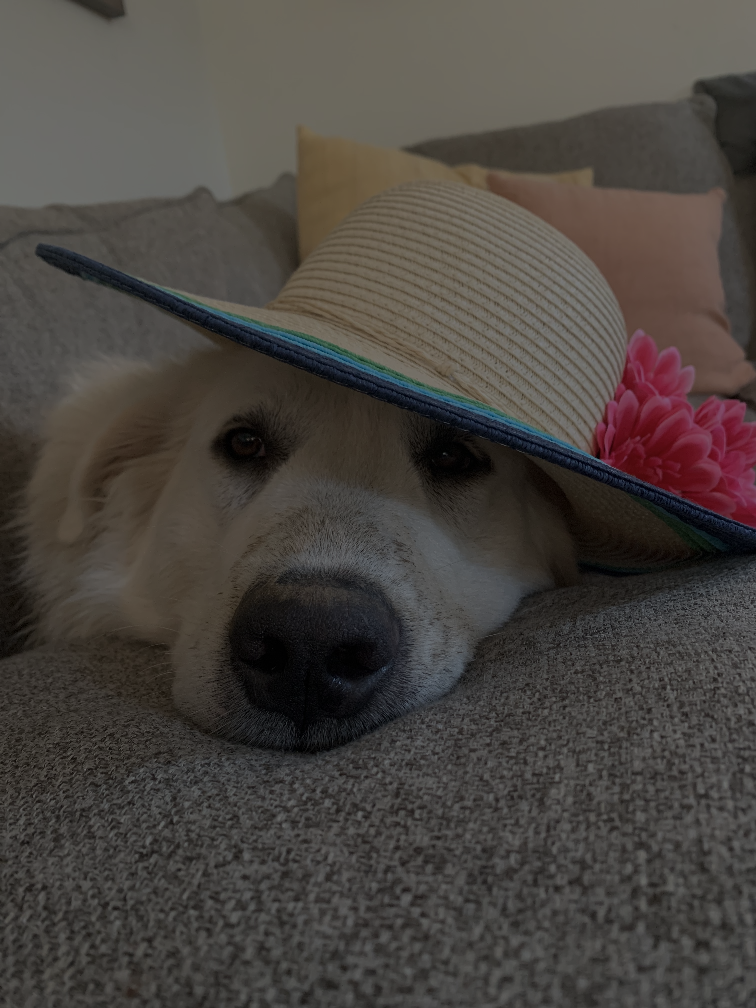

In [6]:
lilly_darker = lilly_gpu .* 0.5
Array(lilly_darker)

Broadcast operations work well for some things, but to get at more complicated operations, we sometimes need to write our operations as GPU kernels directly. Let's implement a basic translation operation, using KernelAbstractions.jl:

In [7]:
@kernel function translate_kernel(out, inp, translation)
    x_idx, y_idx = @index(Global, NTuple)

    x_outidx = x_idx + translation[1]
    y_outidx = y_idx + translation[2]

    if (1 <= x_outidx <= size(out,1)) &&
       (1 <= y_outidx <= size(out,2))
        out[x_outidx, y_outidx] = inp[x_idx, y_idx]
    end
end

translate_kernel (generic function with 5 methods)

Let's use Dagger to execute this! You'll notice in the following function that we can have either an `Array` or a `CuArray` as an argument, and that'll be the same type of array that we return; when using Dagger and DaggerGPU, Dagger's scheduler will schedule the work on either a CPU or a GPU. Importantly, the scheduler will *automatically* convert arrays to-and-from the right type (like how we specify an `Array` to `translate_dagger` below, even though we'll be executing on the GPU). The scheduler also handles all data movement, getting data from where it is to where it needs to be in order for execution to proceed.

In [8]:
function translate_dagger(lilly_inp::T) where {T<:Union{Array,CuArray}}
    lilly_moved = similar(lilly_inp)::T
    lilly_moved .= RGB(0)
    wait(translate_kernel(dagger_backend())(lilly_moved, lilly_inp, (-500, 500); ndrange=size(lilly_inp), workgroupsize=(32,32)))
    lilly_moved::T
end

translate_dagger (generic function with 1 method)

Conveniently, we can now pass an `Array` object to Dagger, and Dagger will do the operation (including any necessary argument conversions), *and* Dagger will convert the return type (which is initially `CuArray`) back into an `Array` when we call `fetch`:

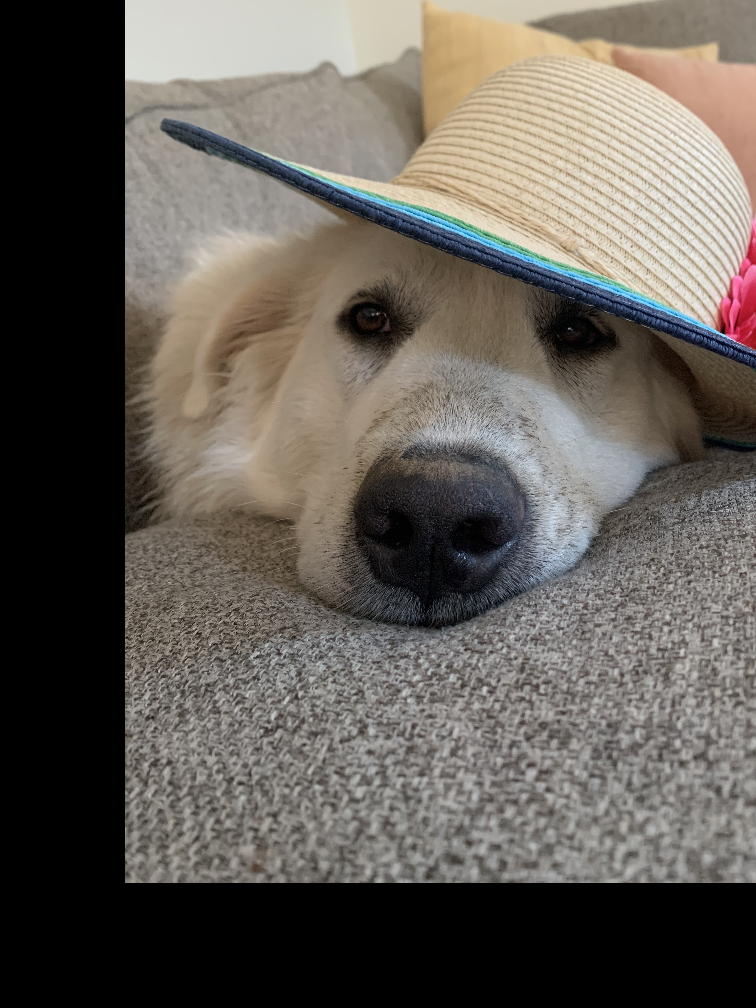

In [9]:
fetch(Dagger.@spawn proclist=gpu_proclist translate_dagger(lilly))::Array

It works! And thanks to the `dagger_backend()` call that we use above, this Dagger kernel is agnostic to whether Dagger is executing it on a CPU or GPU. We can see that difference in the operation's runtime:

In [10]:
# Execute on the CPU
@btime fetch(Dagger.@spawn proclist=cpu_proclist translate_dagger(lilly));

  97.543 ms (983 allocations: 34.93 MiB)


In [11]:
# Execute on a GPU
@btime fetch(Dagger.@spawn proclist=gpu_proclist translate_dagger(lilly));

  43.801 ms (1088 allocations: 34.94 MiB)


Something important to note is that the Julia GPU ecosystem has intentionally chosen not to directly implement seamless execution on GPUs and CPUs simultaneously. If they did, we'd be fraught with users angry that the GPU packages put their very expensive operation on a CPU, or moved around data too much, dominating the computation. Why? Because it's hard to guess what operation comes next, and what hardware would be best suited to execute it.

Dagger, on the other hand, knows all about your problem's structure (since you submit it as a DAG), as well as your hardware configuration, the performance of given operations, network speed, and various other metrics. This makes it possible for Dagger's scheduler to choose an optimal schedule for you at runtime, and tune that schedule as your program executes.

This is different from programming with conventional APIs like MPI; you don't need to be a hardware and software expert to get great performance, scalability, and portability, you just tell Dagger about your program, and Dagger does the rest.



Now that we've seen how to write and execute kernels with Dagger and KernelAbstractions, let's continue with the rest of our image operations. Here's a naive scale operation (no anti-aliasing):

In [12]:
@kernel function scale_kernel(out, inp, scale)
    x_idx, y_idx = @index(Global, NTuple)

    x_outidx = unsafe_trunc(Int, x_idx * scale[1])::Int
    y_outidx = unsafe_trunc(Int, y_idx * scale[2])::Int

    if (1 <= x_outidx <= size(out,1)) &&
       (1 <= y_outidx <= size(out,2))
        out[x_outidx, y_outidx] = inp[x_idx, y_idx]
    end
end

scale_kernel (generic function with 5 methods)

In [13]:
function scale_dagger(lilly_inp)
    lilly_scaled = similar(lilly_inp)
    lilly_scaled .= RGB(0)
    wait(scale_kernel(dagger_backend())(lilly_scaled, lilly_inp, (0.5, 0.2); ndrange=size(lilly_inp), workgroupsize=(32,32)))
    lilly_scaled
end

scale_dagger (generic function with 1 method)

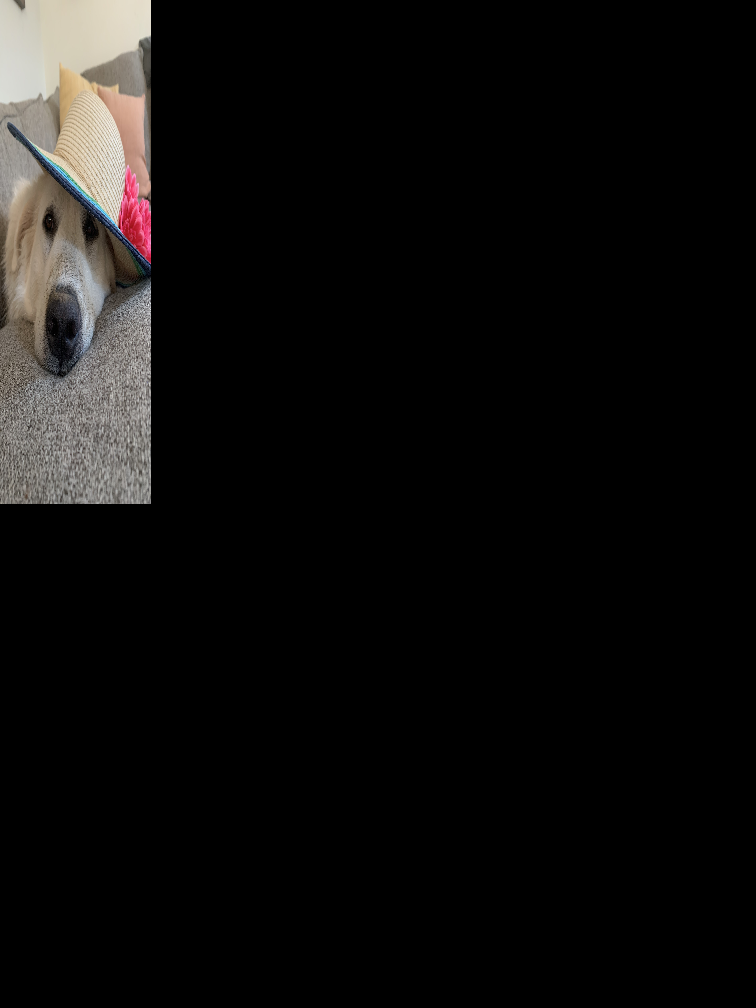

In [14]:
fetch(Dagger.@spawn proclist=gpu_proclist scale_dagger(lilly))

In [15]:
@btime fetch(Dagger.@spawn proclist=cpu_proclist scale_dagger(lilly));

  118.091 ms (1051 allocations: 34.94 MiB)


In [16]:
@btime fetch(Dagger.@spawn proclist=gpu_proclist scale_dagger(lilly));

  44.680 ms (1112 allocations: 34.94 MiB)


Finally, let's rotate this puppy:

In [17]:
@kernel function rotate_kernel(out, inp, angle)
    x_idx, y_idx = @index(Global, NTuple)

    x_centidx = x_idx - (size(inp,1)÷2)
    y_centidx = y_idx - (size(inp,2)÷2)
    x_outidx = unsafe_trunc(Int, (x_centidx*cos(angle)) + (y_centidx*-sin(angle)))::Int
    y_outidx = unsafe_trunc(Int, (x_centidx*sin(angle)) + (y_centidx*cos(angle)))::Int
    x_outidx += (size(inp,1)÷2)
    y_outidx += (size(inp,2)÷2)

    if (1 <= x_outidx <= size(out,1)) &&
       (1 <= y_outidx <= size(out,2))
        out[x_outidx, y_outidx] = inp[x_idx, y_idx]
    end
end

rotate_kernel (generic function with 5 methods)

In [25]:
function rotate_dagger(lilly_inp)
    lilly_rotated = similar(lilly_inp)
    lilly_rotated .= RGB(0)
    wait(rotate_kernel(dagger_backend())(lilly_rotated, lilly_inp, deg2rad(145); ndrange=size(lilly_inp), workgroupsize=(32,1)))
    lilly_rotated
end

rotate_dagger (generic function with 1 method)

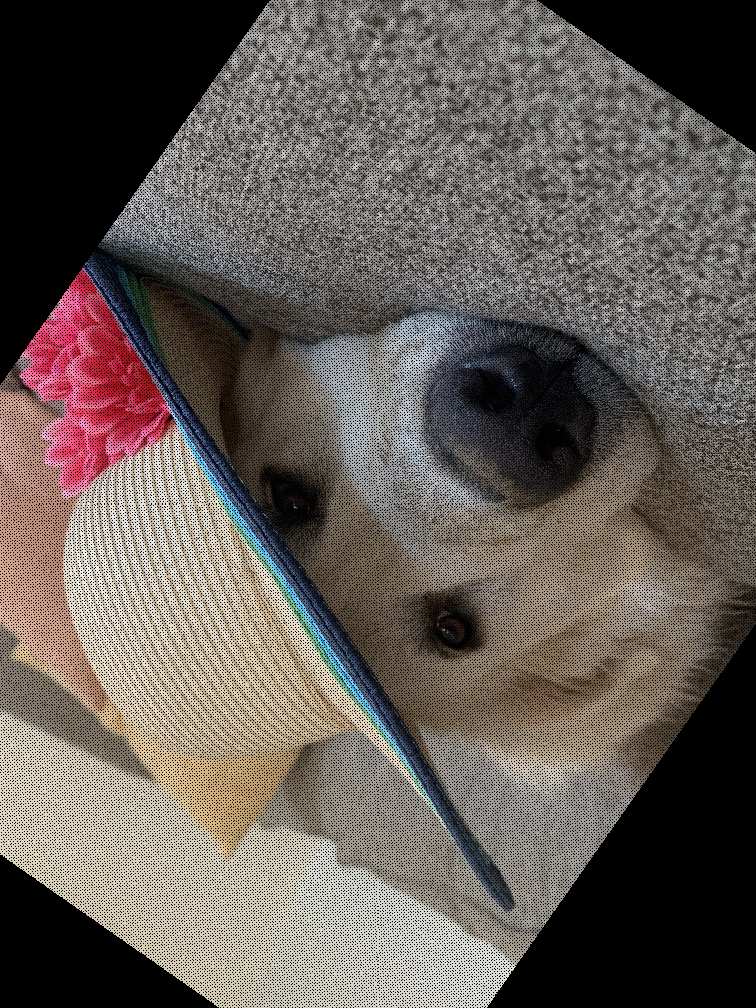

In [26]:
fetch(Dagger.@spawn proclist=gpu_proclist rotate_dagger(lilly))

In [27]:
@btime fetch(Dagger.@spawn proclist=cpu_proclist rotate_dagger(lilly));

  928.814 ms (1221 allocations: 34.94 MiB)


In [28]:
@btime fetch(Dagger.@spawn proclist=gpu_proclist rotate_dagger(lilly));

  48.440 ms (1111 allocations: 34.94 MiB)


Awesome! Those 3 operations are foundational to image processing, and they were easy to implement in Julia!

Thanks to the power and flexibility of Dagger and KernelAbstractions, we can write kernels once, and execute them anywhere.